# Basic Flood Inundation Mapping using Height Above Nearest Drainage

**Authors:**  
   - Tony Castronova <acastronova@cuahsi.org>    
   - Irene Garousi-Nejad <igarousi@cuahsi.org>  
    
**Last Updated:** 05.22.2024

**Description**:  

The purpose of this Jupyter Notebook is to demonstrate the process of generating flood inundation maps (FIM) using pre-computed Height Above Nearest Drainage (HAND) raster maps. This process has been developed by the NOAA Office of Water Prediction, see the [inundation-mapping project](https://github.com/NOAA-OWP/inundation-mapping) for more information. 

There are two approaches to using the data provided by NOAA OWP to compute FIM; basic (simplified) mapping and mosaic mapping. The latter represents the state of practice in this domain, however for simplicity this notebook will demonstrate the former. After understanding the simplified approach it will be clear how to extend this work to the more complex *mosaic* methodology.

The FIM approach outlined in this notebook requires several input datasets. These can be obtained from the ESIP-hosted cloud store using the following commands (note: full instructions are provided in repository linked above):

```
aws s3 ls s3://noaa-nws-owp-fim/hand_fim/  

aws s3 sync s3://noaa-nws-owp-fim/hand_fim/outputs/fim_4_4_0_0/12090301 \
    /your_local_folder_name/12090301 
```

**Data Description**

- `hydroTable_0.csv`: pre-computed reach rating curves.
- `rem_zeroed_masked_0.tif`: pre-computed HAND raster grid.
- `gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg`: added attributes for reaches.
- `demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg`: DEM-derived reach geometries, used for visualization.

**Software Requirements**:  

The software and operating system versions used to develop this notebook are listed below. To avoid encountering issues related to version conflicts among Python packages, we recommend creating a new environment variable and installing the required packages specifically for this notebook.

Tested on: MacOS Ventura 13.2.1  

> boto3: 1.26.76  
  dask-core: 2023.4.0  
  fiona: 1.9.3  
  fsspec: 2023.4.0  
  geopandas: 0.12.2   
  ipyleaflet: 0.17.2  
  ipywidgets: 7.7.5   
  matplotlib: 3.7.1   
  netcdf4: 1.6.3   
  numpy: 1.24.2  
  pandas: 2.0.0  
  requests: 2.28.2  
  s3fs: 2023.4.0  
  scipy: 1.10.1  
  xarray: 2023.4.1
  
**Supplementary Code**

To simplify this notebook several *helper* functions have been develop that are referenced. These functions are located in a module called `nwm_utils`.

In [1]:
import numpy
import xarray
import rioxarray
import geopandas
import numpy as np
import pandas as pd
from typing import Dict
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube
from geocube.vector import vectorize

from sidecar import Sidecar
import ipyleaflet

In [11]:
from nwm_utils.fim import map, xfim

In [23]:
geodf_reaches = geopandas.read_file(Path('./demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg'))
transformed_reaches = geodf_reaches.to_crs(epsg='4326')

In [4]:
sc = map.SideCarMap(gdf=transformed_reaches)
sc.display_map()

Creating Base Map...0.00 sec
Adding USGS Gages...0.00 sec
Adding NHD+ Reaches...0.00 sec
Adding Geopandas Features...13.15 sec
Rendering Map...1.25 sec


In [6]:
sc.selected()

S0                                                      0.00415
LengthKm                                                1.47267
LakeID                                                   -999.0
HydroID                                                15853613
From_Node                                                  4903
To_Node                                                    3196
NextDownID                                             15851900
feature_id                                              2091343
order_                                                        1
areasqkm                                                 3.1343
ManningN                                                   0.06
geometry      LINESTRING (-83.90588229180428 38.047826864793...
Name: 3587, dtype: object

In [19]:
nhd_feature_id = sc.selected().feature_id

Define a hypothetical streamflow. This can be easily replaced with logic to compute streamflow based on historical flows.

In [8]:
# hypothetical streamflow (cms).
# This can be replaced with a flow value gathered by a source of your choice
cms = 500

Use the streamflow defined above to interpolate river stage from a rating curve for all hydroids that exist within this NHD+ reach. 

In [20]:
stage_dict = xfim.get_stage_for_all_hydroids_in_reach(int(nhd_feature_id), cms)
stage_dict

{15853612: 3.797830105435464, 15853613: 4.03325711731366}

Load the precomputed HAND raster.

In [21]:
xds = rioxarray.open_rasterio(Path('./rem_zeroed_masked_0.tif'),
                              masked=True).squeeze().drop_vars('band').to_dataset(name='hand')
xds

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 18146, y: 17087)
Coordinates:
  * x            (x) float64 145kB 9.684e+05 9.684e+05 ... 1.15e+06 1.15e+06
  * y            (y) float64 137kB 1.85e+06 1.85e+06 ... 1.679e+06 1.679e+06
    spatial_ref  int64 8B 0
Data variables:
    hand         (y, x) float32 1GB ...

Make a copy of the 'hand' variable to the 'stage' variable. This will be used to compute the flood inundation map later on. The dataset will now have both `hand` and `stage` variables for all (x,y) locations.

In [22]:
xds['stage'] = xds.hand.copy(deep=True)
xds

<xarray.Dataset> Size: 2GB
Dimensions:      (x: 18146, y: 17087)
Coordinates:
  * x            (x) float64 145kB 9.684e+05 9.684e+05 ... 1.15e+06 1.15e+06
  * y            (y) float64 137kB 1.85e+06 1.85e+06 ... 1.679e+06 1.679e+06
    spatial_ref  int64 8B 0
Data variables:
    hand         (y, x) float32 1GB ...
    stage        (y, x) float32 1GB ...

Read watershed geometries and set stage values from the `stage_dict` defined above, and remove all other geometries. The end product will be a geodataframe containing the geometries for each `hydroid` in our area of interest and their stage values.

In [24]:
geodf = geopandas.read_file(Path('./gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg'))

# loop over each reach and set the corresponding stage
# in the geopandas object
for hydroid, stage in stage_dict.items():
    geodf.loc[geodf.HydroID==hydroid, 'stage'] = stage

# remove all nan values to make our dataset smaller
geodf_filtered = geodf[geodf.stage.notnull()]

# isolate only reaches we're interested in to make our dataset smaller
geodf_reaches_filtered = geodf_reaches[geodf_reaches.feature_id == nhd_feature_id]

geodf_filtered

,HydroID,S0,LengthKm,LakeID,From_Node,To_Node,NextDownID,areasqkm,feature_id,order_,src_calibrated,geometry,stage
4137,15853613,0.004150,1.472670,-999.0,4903,3196,15851900,3.1343,2091343,1,False,"POLYGON ((1048639.409 1736584.282, 1048649.409...",4.033257
4200,15853612,0.006813,1.491249,-999.0,4902,4903,15853613,6.3357,2091343,1,False,"POLYGON ((1047789.409 1737234.282, 1047809.409...",3.797830


Visualize the area that we're working with.

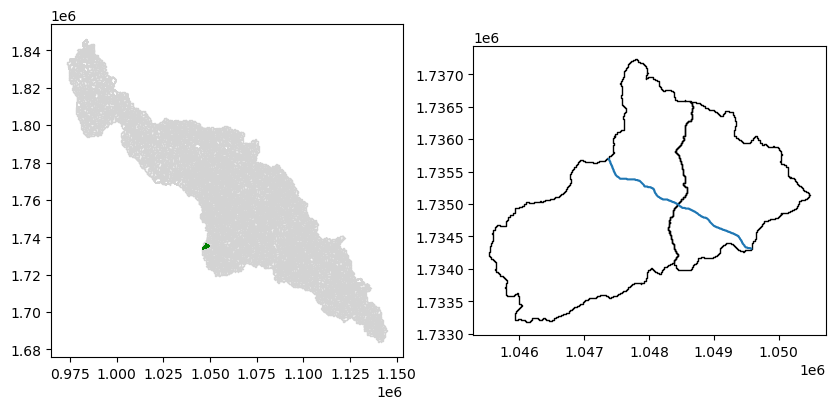

In [25]:
figure, axes = plt.subplots(1, 2, figsize=(10, 10))

geodf.plot(facecolor='None', edgecolor='lightgrey', ax=axes[0]);
geodf_filtered.plot(facecolor='green', ax=axes[0]);

geodf_filtered.plot(facecolor='None', ax=axes[1]);
geodf_reaches_filtered.plot(ax=axes[1]);

Add all geometries to the Dataset containing `hand` and `stage` variables using a GeoCube.

In [26]:
# create a grid for the geocube
out_grid = make_geocube(
    vector_data=geodf,
    measurements=['HydroID'],
    like=xds # ensure the data are on the same grid
)

# add stage and hydroID to the HAND raster
ds = xds.assign_coords( hydroid = (['y', 'x'], out_grid.HydroID.data) )

# drop everything except the HydroIDs that we're interested in
ds = ds.where(ds.hydroid.isin(geodf_filtered.HydroID), drop=True)
ds

<xarray.Dataset> Size: 3MB
Dimensions:      (y: 406, x: 494)
Coordinates:
  * x            (x) float64 4kB 1.046e+06 1.046e+06 ... 1.05e+06 1.05e+06
  * y            (y) float64 3kB 1.737e+06 1.737e+06 ... 1.733e+06 1.733e+06
    spatial_ref  int64 8B 0
    hydroid      (y, x) float64 2MB nan nan nan ... 1.585e+07 1.585e+07
Data variables:
    hand         (y, x) float32 802kB nan nan nan nan nan ... nan nan nan nan
    stage        (y, x) float32 802kB nan nan nan nan nan ... nan nan nan nan

Update the stage values in the DataSet where specific hydroid's exist.

In [27]:
for idx, row in geodf_filtered.iterrows():
    print(f'{row.HydroID} -> {row.stage}' )
    ds['stage'] = xarray.where(ds.hydroid == row.HydroID, row.stage, ds.stage)

15853613 -> 4.03325711731366
15853612 -> 3.797830105435464


Preview the `stage` data we set as well as the original `hand` data. 

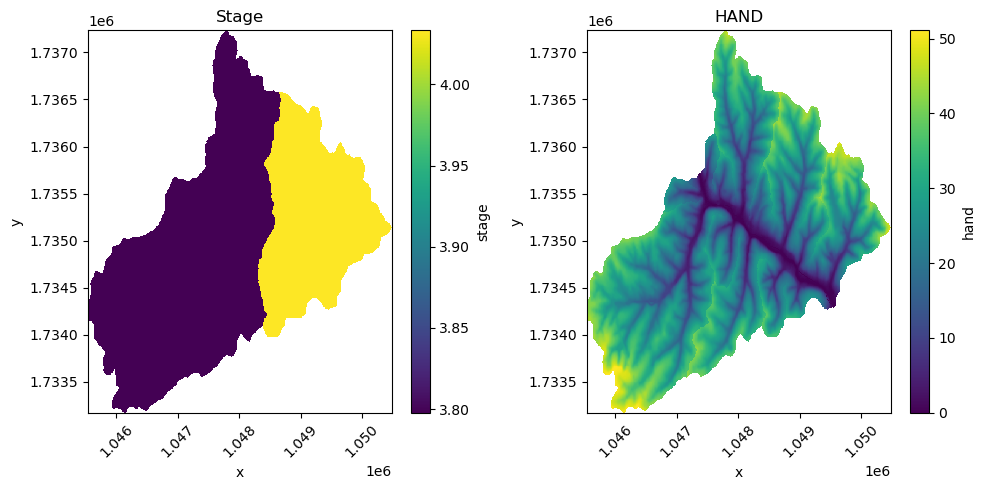

In [28]:
figure, axes = plt.subplots(1, 2, figsize=(10,5))

# plot stage
ds.stage.plot(ax=axes[0])
axes[0].set_title('Stage');
axes[0].tick_params(axis='x', labelrotation=45)

# plot hand
ds.hand.plot(ax=axes[1])
axes[1].set_title('HAND');
axes[1].tick_params(axis='x', labelrotation=45)

figure.tight_layout()


Compute FIM by subtracting `hand` from `stage`. Everything that is negative should be set to zero. Cells that have a value greater than zero indicate areas in which flooding occurs. Create a new variable in our dataset (called `fim`) to store this result.

In [29]:
ds['fim'] = ds.stage - ds.hand
ds['fim'] = xarray.where(ds.fim >= 0.00001, ds.fim, numpy.nan)

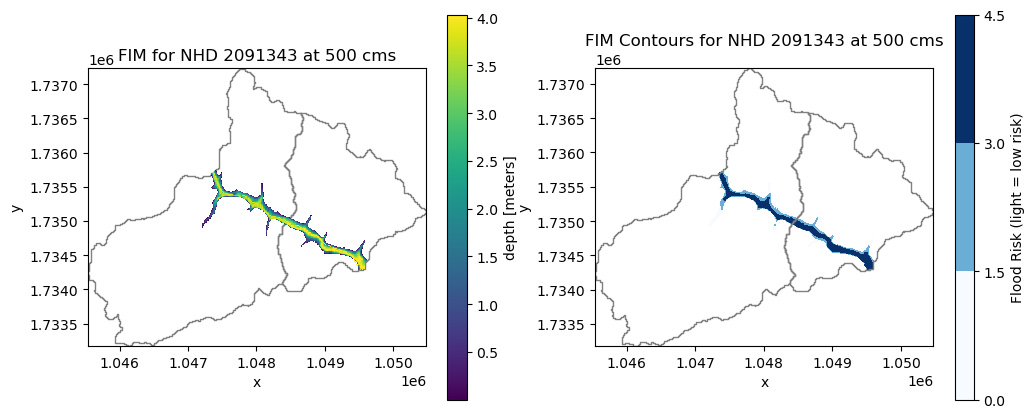

In [30]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))

geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[0], edgecolor='grey', facecolor='None');
ds.fim.plot(cbar_kwargs={'label':'depth [meters]'}, ax=axes[0]);
axes[0].set_title(f'FIM for NHD {nhd_feature_id} at {cms} cms');


xarray.plot.contourf(ds.fim, levels=4, cmap='Blues', cbar_kwargs={'label':'Flood Risk (light = low risk)'}, ax=axes[1]);
geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[1], edgecolor='grey', facecolor='None');
axes[1].set_title(f'FIM Contours for NHD {nhd_feature_id} at {cms} cms');


In [196]:
# drop nans
da = ds.fim
df = vectorize(da)
df = df[df.fim.notna()]

In [200]:
transformed_fim = df.to_crs(epsg='4326')
poly = transformed_fim.dissolve()
poly.fim = 1

In [201]:
wlayer = ipyleaflet.WKTLayer(
            wkt_string=poly.iloc[0].geometry.wkt,
            style={'color': 'red', 'opacity':.5, 'weight':1.9,})
sc.map.add(wlayer);